In [2]:
import pandas as pd
from tqdm import tqdm
import warnings
from causis_api.const import get_version
from causis_api.const import login


login.username = "chen.sun"
login.password = "Sc2285249034@"
login.version = get_version()
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from causis_api.data import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm,decomposition,metrics
import matplotlib.pyplot as plt

In [4]:
from datetime import datetime

# 1. 数据整合

In [5]:
index = get_price('S.CN.SZSE.399001','2010-01-01', end_date='2021-12-31', frequency='day',  market='cn')
index = index[['Clock','Symbol','Close']]
index = index.rename(columns = {'Close':'Index_Close'})
index = index.set_index('Clock')
index.index = pd.to_datetime(index.index)

In [6]:
filepath = 'D:/实习/Week1/股票行情及估值数据/stock_price_standard'
filepath1 = 'D:/实习/Week1/股票行情及估值数据/stock_valuation_standard'
filepath2 = 'D:/实习/Week1/股票行情及估值数据/stock_st_standard'
stock_data = pd.read_pickle(filepath).reset_index().set_index('level_1')
stock_valuation = pd.read_pickle(filepath1).reset_index().set_index('level_1')
stock_st = pd.read_pickle(filepath2).reset_index().set_index('level_1')


stock = pd.DataFrame()
for tick in tqdm(stock_data['level_0'].unique()):
    
    # 合成数据列表
    close_price = stock_data[stock_data['level_0']==tick].iloc[0:1,1:-24].transpose()
    factors = stock_valuation[stock_valuation['level_0']==tick].iloc[:,1:-24].transpose()
    st = stock_st[stock_st['level_0']==tick].iloc[0,1:-24].transpose()
    stock_v = pd.concat([close_price,factors,st],axis=1)
    stock_v.index = pd.to_datetime(stock_v.index)
    stock_v = pd.merge(stock_v,index,left_index=True,right_index=True)
    stock_v = stock_v.dropna()
    
    #因子去极值
    stock_v[['PBRatio','PeRatio']] = stock_v[['PBRatio','PeRatio']].applymap(lambda x: np.nan if x <= 0 else x)
    stock_v = stock_v.dropna()
    upper_bound_PB = 100
    stock_v['PBRatio'] = stock_v['PBRatio'].clip(upper=upper_bound_PB)
    upper_bound_PE = 100
    stock_v['PeRatio'] = stock_v['PeRatio'].clip(upper=upper_bound_PE)
    
    #构建下一期超额回报
    stock_v['Return'] = stock_v['Close'].pct_change()
    stock_v['Excess_Return'] = stock_v['Return'] - stock_v['Index_Close'].pct_change()
    stock_factors = stock_v.resample('M').last()
    stock_factors['Index_Return'] = stock_v[['Index_Close']].pct_change().resample('M').sum().shift(-1)
    stock_factors['Monthly_Return'] = stock_v['Return'].resample('M').sum().shift(-1)
    stock_factors['Excess_Return'] = stock_v['Excess_Return'].resample('M').sum().shift(-1) 
    stock_factors['Code'] = tick
    stock_factors['deviation_factor'] = stock_v['Return'].resample('M').std()
    stock = pd.concat([stock,stock_factors],axis=0).dropna()
                                     
stock['Trade_status'] = 1
for i in range (0,len(stock)):
    if stock['TurnoverRatio'][i]== 0:
        stock['Trade_status'][i] = 0
    elif stock['IsST'][i] == True:
        stock['Trade_status'][i] = 0

for tick in stock.Code.unique():
    if stock[stock['Code']==tick].index[0] > stock.index[0]:
        stock[stock['Code']==tick]['Trade_status'][0:3] = 0
        
stock = stock.reset_index().rename(columns = {'index':'Date'})
stock = stock.sort_values(by = 'Date').reset_index().iloc[:,1:]
stock

100%|██████████████████████████████████████████████████████████████████████████████| 1410/1410 [01:37<00:00, 14.52it/s]


,Date,Close,Capitalization,CirculatingCap,CirculatingMarketCap,MarketCap,PBRatio,PCFRatio,PSRatio,PeRatio,...,IsST,Symbol,Index_Close,Return,Excess_Return,Index_Return,Monthly_Return,Code,deviation_factor,Trade_status
0,2010-01-31,10.710000,115000.000000,101500.000000,108.706497,123.165001,2.0435,76.553101,3.930300,25.166800,...,False,S.CN.SZSE.399001,12137.20,0.000000,0.072310,0.025739,0.098049,S.CN.SSE.600004,0.024261,1
1,2010-01-31,29.000000,17880.000000,3600.000000,10.440000,51.852001,3.5281,40.653900,7.295000,40.001999,...,False,S.CN.SZSE.399001,12137.20,-0.006849,0.021740,0.025739,0.047480,S.CN.SZSE.002303,0.020445,1
2,2010-01-31,15.230000,64476.371094,46478.980469,70.787498,98.197502,3.5631,-38.208401,6.497700,21.053400,...,False,S.CN.SZSE.399001,12137.20,0.015333,0.001024,0.025739,0.026763,S.CN.SZSE.001872,0.025922,1
3,2010-01-31,9.580000,100096.796875,33007.613281,31.621300,95.892700,20.8228,18.626400,3.797000,30.508699,...,True,S.CN.SZSE.399001,12137.20,0.001045,0.109568,0.025739,0.135307,S.CN.SSE.600223,0.027281,0
4,2010-01-31,29.000000,23711.871094,10497.607422,30.443100,68.764397,26.1677,55.046001,26.681200,57.277000,...,False,S.CN.SZSE.399001,12137.20,0.000000,-0.078391,0.025739,-0.052652,S.CN.SSE.600139,0.032951,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156660,2021-11-30,16.120001,29781.000000,29781.000000,48.007000,48.007000,1.2434,-37.257301,3.410200,20.213600,...,False,S.CN.SZSE.399001,14795.73,0.009393,0.023620,0.005192,0.028813,S.CN.SSE.600897,0.027585,1
156661,2021-11-30,5.330000,102480.539062,94544.031250,50.391998,54.622101,2.5232,24.884199,46.061501,52.273499,...,True,S.CN.SZSE.399001,14795.73,0.034951,-0.020613,0.005192,-0.015421,S.CN.SSE.600896,0.027803,0
156662,2021-11-30,14.860000,154868.953125,154868.953125,230.135300,230.135300,2.0786,18.548000,12.356200,13.717700,...,False,S.CN.SZSE.399001,14795.73,0.007458,0.009183,0.005192,0.014375,S.CN.SSE.600895,0.018619,1
156663,2021-11-30,8.450000,157134.000000,155600.000000,131.481995,132.778198,2.8743,-21.607800,1.761100,33.322201,...,False,S.CN.SZSE.399001,14795.73,-0.003538,-0.009492,0.005192,-0.004299,S.CN.SSE.600917,0.018786,1


In [7]:
factor_table = stock[['Date','Code','Trade_status','Close','Excess_Return','Monthly_Return','Index_Return','deviation_factor']]
factor_table

,Date,Code,Trade_status,Close,Excess_Return,Monthly_Return,Index_Return,deviation_factor
0,2010-01-31,S.CN.SSE.600004,1,10.710000,0.072310,0.098049,0.025739,0.024261
1,2010-01-31,S.CN.SZSE.002303,1,29.000000,0.021740,0.047480,0.025739,0.020445
2,2010-01-31,S.CN.SZSE.001872,1,15.230000,0.001024,0.026763,0.025739,0.025922
3,2010-01-31,S.CN.SSE.600223,0,9.580000,0.109568,0.135307,0.025739,0.027281
4,2010-01-31,S.CN.SSE.600139,0,29.000000,-0.078391,-0.052652,0.025739,0.032951
...,...,...,...,...,...,...,...,...
156660,2021-11-30,S.CN.SSE.600897,1,16.120001,0.023620,0.028813,0.005192,0.027585
156661,2021-11-30,S.CN.SSE.600896,0,5.330000,-0.020613,-0.015421,0.005192,0.027803
156662,2021-11-30,S.CN.SSE.600895,1,14.860000,0.009183,0.014375,0.005192,0.018619
156663,2021-11-30,S.CN.SSE.600917,1,8.450000,-0.009492,-0.004299,0.005192,0.018786


# 2. 构建策略复现必备模型

In [8]:
class Parameter:
    method = 'SVM'
    seed = 42
    month_in_sample = '2017-12-31'
    svm_kernel = 'linear'
    percent_select = [0.3,0.3]
    n_stock_buy = [10,30,60,80,100,120,150]
    capital = 10000000
    percent_cv = 0.1
    svm_c = 0.1
para = Parameter()

In [32]:
def build_factor(df):
    df['MarketCap_factor'] = np.log(stock['MarketCap'])
    df['BP_factor'] = 1/stock['PBRatio']
    df['EP_factor'] = 1/stock['PeRatio']
    df = df.rename(columns = {'Date':'StatDate'})
    factors_new = pd.DataFrame()
    for tick in tqdm(df.Code.unique()):
        try:
            public_month = df[df['Code']==tick]['StatDate'].iloc[0]
            quality = get_indicator(tick,public_month,'2021-12-31')[['StatDate','EPS','ROE','OperatingProfit','AdjustedProfit']]
            quality['StatDate'] = pd.to_datetime(quality['StatDate'])
            quality = quality.set_index('StatDate')
            quality = quality.resample('M').ffill()
            quality = quality.reset_index()
            quality['Code'] = tick
            quality = quality[quality['StatDate']> public_month]
            factors_new = pd.concat([factors_new,quality],axis=0)
        except Exception:
            continue
    factors_new['StatDate'] = pd.to_datetime(factors_new['StatDate'])
    factor_table_new = pd.merge(df,factors_new,on=['StatDate','Code'])
    factor_table_new = factor_table_new[(factor_table_new['OperatingProfit'] != 0.)&(factor_table_new['AdjustedProfit'] != 0.)]
    factor_table_new['OP_factor'] = np.log(factor_table_new['OperatingProfit'])
    factor_table_new = factor_table_new.dropna()
    factor_table_new = factor_table_new.drop(['OperatingProfit', 'AdjustedProfit'], axis=1)
    factor_table_new = factor_table_new.sort_values(by = ['StatDate','Code'])
    factor_table_new['Selected']=np.nan
    return factor_table_new


def label_data(df):
    labeled_table = pd.DataFrame()
    for date in df.StatDate.unique(): 
        table = df[(df['StatDate']==date)&(df['Trade_status']==1)].sort_values(by='Excess_Return',ascending = False)
        n_stock_select = np.round(np.multiply(para.percent_select,len(table))).astype(int)
        table.iloc[0:n_stock_select[0],-1] = 1
        table.iloc[-n_stock_select[1]:,-1] = 0 
        table = table.dropna(axis=0)
        labeled_table = pd.concat([labeled_table,table],axis = 0)
    return labeled_table  

def svm_train(df):
    X_in_sample = label_data(df)
    X_in_sample = X_in_sample[X_in_sample['StatDate']<=para.month_in_sample].loc[:,'deviation_factor':'OP_factor']
    y_in_sample = label_data(df)
    y_in_sample = y_in_sample[y_in_sample['StatDate']<=para.month_in_sample].loc[:,'Selected']
    
    X_train, X_test, y_train, y_test = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)

    pca = decomposition.PCA(n_components = 0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)
    
    if para.method == 'SVM':
        model = svm.SVC(kernel = para.svm_kernel,C=para.svm_c)
        model.fit(X_train,y_train)
        y_pred_train = model.predict(X_train)
        y_score_train = model.decision_function(X_train)
        y_pred_test = model.predict(X_test)
        y_score_test = model.decision_function(X_test)
    
    monthly_score = label_data(df)
    curr_month = pd.DataFrame()
    for date in monthly_score[monthly_score['StatDate']>para.month_in_sample].StatDate.unique():
        X_curr_month = monthly_score[monthly_score['StatDate']==date].loc[:,'deviation_factor':'OP_factor']
        X_curr_month = pca.transform(X_curr_month)
        y_curr_month = monthly_score[monthly_score['StatDate']==date].loc[:,'Selected']
        y_pred_curr_month = model.predict(X_curr_month)
        y_score_curr_month = model.decision_function(X_curr_month)
        y_true_curr_month = monthly_score[monthly_score['StatDate']==date].loc[:,['StatDate','Code','Close','Monthly_Return','Index_Return']]
        y_true_curr_month['y_score'] = y_score_curr_month
        curr_month = pd.concat([curr_month,y_true_curr_month])
        print('test set, %s accuracy = %.2f'%(str(date)[0:7],metrics.accuracy_score(y_curr_month,y_pred_curr_month)))
        print('test set, %s AUC = %.2f'%(str(date)[0:7],metrics.roc_auc_score(y_curr_month,y_score_curr_month)))
    return curr_month
 

def back_testing(df,buy):
    portfolio_sum = pd.DataFrame()
    for i in range(0,len(para.n_stock_buy)):
        n_stock = buy[i]
        NAV = 1
        index_NAV = 1
        portfolio = pd.DataFrame({'Strategy'+str(i+1)+'_Return':0,
                                  'Strategy'+str(i+1)+'_NAV':1},index=[pd.to_datetime('2018-01-01')])
        benchmark_return = [0]
        benchmark_NAV = [1]
        for date in df.StatDate.unique():
            true_return = df[df['StatDate']==date].sort_values(by='y_score',ascending=False)
            simple_return = np.mean(true_return[0:n_stock]['Monthly_Return'])
            index_return = np.mean(true_return[0:n_stock]['Index_Return'])
            NAV = NAV + simple_return
            index_NAV = index_NAV + index_return
            data_table = pd.DataFrame({'Strategy'+str(i+1)+'_Return':simple_return,
                                       'Strategy'+str(i+1)+'_NAV':NAV},index=[date])
            benchmark_return.append(index_return)
            benchmark_NAV.append(index_NAV)
            portfolio = pd.concat([portfolio,data_table],axis=0) 
            
        portfolio_sum = pd.concat([portfolio_sum,portfolio],axis = 1)
    
    portfolio_sum['Benchmark_Return'] = benchmark_return
    portfolio_sum['Benchmark_NAV'] = benchmark_NAV
    portfolio_sum=portfolio_sum.reset_index()
    portfolio_sum['index']=portfolio_sum['index'].shift(-1)
    portfolio_sum=portfolio_sum.dropna()
    portfolio_sum=portfolio_sum.set_index('index')
    return portfolio_sum

def strategy_evaluation(df):
    evaluation = pd.DataFrame()
    for i in range(0,len(para.n_stock_buy)):
        annual_return = np.mean(df['Strategy'+str(i+1)+'_Return']) * 12
        annual_volatility = np.std(df['Strategy'+str(i+1)+'_Return']) * np.sqrt(12)
        info_ratio = annual_return/annual_volatility
        max_drawdown = 0
        running_max = df['Strategy'+str(i+1)+'_NAV'][0]
        
        for nav in df['Strategy'+str(i+1)+'_NAV']:
            if nav > running_max:
                running_max = nav
            else:
                drawdown = ((running_max - nav) / running_max)*100
                if drawdown > max_drawdown:
                    max_drawdown = drawdown
                    
        evaluation_new = pd.DataFrame({'Strategy':'Strategy'+str(i+1),
                                       'Annual Return':annual_return,
                                       'Annual Volatility':annual_volatility,
                                       'Info Ratio':info_ratio,
                                       'Max Drawdown':max_drawdown},index=[i+1])
        evaluation = pd.concat([evaluation,evaluation_new],axis=0)
    return evaluation

def graph(df):
    plt.figure(figsize=[10,6])
    plt.xlabel('Date',fontsize = 12)
    plt.ylabel('Net Asset Value',fontsize = 12)
    plt.title('Net Asset Value Trend Graph',fontsize = 16)
    for i in range(0,len(para.n_stock_buy)):
        plt.plot(df['Strategy'+str(i+1)+'_NAV'],label = 'buy top '+str(para.n_stock_buy[i])+' stock')
    plt.plot(df['Benchmark_NAV'],label = 'Index')
    plt.legend()
    plt.grid()
    plt.show()
    
def Sensitivity(df):
    plt.figure(figsize=[10,6])
    plt.plot(para.n_stock_buy, df['Info Ratio'])
    plt.xlabel('Number of stock in portfolio',fontsize = 12)
    plt.ylabel('Info Ratio',fontsize = 12)
    plt.title('Sensitivity Test',fontsize = 16)
    plt.grid()
    plt.show()
    
     
def trading_book(df,buy):
    df['Signal'] = 0
    df['Trade Volume'] = 0.
    n_stock = buy
    trade_book = pd.DataFrame()
    for date in df.StatDate.unique():
        trade = df[df['StatDate']==date].sort_values(by='y_score',ascending=False)
        trade['Signal'].iloc[0:n_stock] = 1
        trade = trade[trade['Signal']==1]
        per_capital = para.capital/n_stock
        trade['Trade Volume'].iloc[0:n_stock] = np.ceil(per_capital/(100*trade['Close'].iloc[0:n_stock]))
        trade['Monthly_Profit'] = trade['Trade Volume']*trade['Close']*100*(trade['Monthly_Return'])
        
        trade_book = pd.concat([trade_book,trade],axis=0)    
    trade_book = trade_book.rename(columns={'StatDate':'Bought_on'})
    trade_book['Sell_Date']=trade_book['Bought_on'].shift(-n_stock).fillna(datetime(2021,12,31))
    return trade_book

def trading_cost(df,buy):
    portfolio_sum = pd.DataFrame()
    for i in range(0,len(para.n_stock_buy)):
        n_stock = buy[i]
        NAV = 1
        index_NAV = 1
        trading_cost = 0.0005+0.01
        portfolio = pd.DataFrame({'Strategy'+str(i+1)+'_Return':0,
                                  'Strategy'+str(i+1)+'_NAV':1},index=[pd.to_datetime('2018-01-01')])
        benchmark_return = [0]
        benchmark_NAV = [1]
        for date in df.StatDate.unique():
            true_return = df[df['StatDate']==date].sort_values(by='y_score',ascending=False)
            simple_return = np.mean(true_return[0:n_stock]['Monthly_Return'])-trading_cost
            index_return = np.mean(true_return[0:n_stock]['Index_Return'])
            NAV = NAV + simple_return
            index_NAV = index_NAV + index_return
            data_table = pd.DataFrame({'Strategy'+str(i+1)+'_Return':simple_return,
                                       'Strategy'+str(i+1)+'_NAV':NAV},index=[date])
            benchmark_return.append(index_return)
            benchmark_NAV.append(index_NAV)
            portfolio = pd.concat([portfolio,data_table],axis=0) 
            
        portfolio_sum = pd.concat([portfolio_sum,portfolio],axis = 1)
    
    portfolio_sum['Benchmark_Return'] = benchmark_return
    portfolio_sum['Benchmark_NAV'] = benchmark_NAV
    portfolio_sum=portfolio_sum.reset_index()
    portfolio_sum['index']=portfolio_sum['index'].shift(-1)
    portfolio_sum=portfolio_sum.dropna()
    portfolio_sum=portfolio_sum.set_index('index')
    return portfolio_sum

In [10]:
factor_table_new = build_factor(factor_table)

100%|██████████████████████████████████████████████████████████████████████████████| 1410/1410 [40:26<00:00,  1.72s/it]


In [33]:
curr_month = svm_train(factor_table_new)

test set, 2018-01 accuracy = 0.54
test set, 2018-01 AUC = 0.61
test set, 2018-02 accuracy = 0.52
test set, 2018-02 AUC = 0.56
test set, 2018-03 accuracy = 0.53
test set, 2018-03 AUC = 0.59
test set, 2018-04 accuracy = 0.54
test set, 2018-04 AUC = 0.68
test set, 2018-05 accuracy = 0.54
test set, 2018-05 AUC = 0.62
test set, 2018-06 accuracy = 0.52
test set, 2018-06 AUC = 0.48
test set, 2018-07 accuracy = 0.51
test set, 2018-07 AUC = 0.53
test set, 2018-08 accuracy = 0.48
test set, 2018-08 AUC = 0.49
test set, 2018-09 accuracy = 0.51
test set, 2018-09 AUC = 0.54
test set, 2018-10 accuracy = 0.47
test set, 2018-10 AUC = 0.47
test set, 2018-11 accuracy = 0.50
test set, 2018-11 AUC = 0.57
test set, 2018-12 accuracy = 0.54
test set, 2018-12 AUC = 0.64
test set, 2019-01 accuracy = 0.52
test set, 2019-01 AUC = 0.48
test set, 2019-02 accuracy = 0.52
test set, 2019-02 AUC = 0.58
test set, 2019-03 accuracy = 0.53
test set, 2019-03 AUC = 0.62
test set, 2019-04 accuracy = 0.50
test set, 2019-04 AUC

In [121]:
portfolio = back_testing(curr_month, para.n_stock_buy)

In [122]:
portfolio_cost = trading_cost(curr_month, para.n_stock_buy)

In [123]:
evaluation = strategy_evaluation(portfolio)
evaluation

,Strategy,Annual Return,Annual Volatility,Info Ratio,Max Drawdown
1,Strategy1,0.412771,0.331803,1.244023,34.831388
2,Strategy2,0.409484,0.256419,1.596935,24.165230
3,Strategy3,0.393569,0.234591,1.677684,23.233962
4,Strategy4,0.416377,0.219680,1.895375,18.028031
5,Strategy5,0.387703,0.209729,1.848591,19.855299
6,Strategy6,0.374030,0.201872,1.852806,19.645582
7,Strategy7,0.360196,0.203457,1.770378,20.907924


In [124]:
evaluation_cost = strategy_evaluation(portfolio_cost)
evaluation_cost

,Strategy,Annual Return,Annual Volatility,Info Ratio,Max Drawdown
1,Strategy1,0.289452,0.331567,0.872981,46.381388
2,Strategy2,0.286165,0.256116,1.117328,30.684955
3,Strategy3,0.270250,0.234274,1.153561,31.314179
4,Strategy4,0.293058,0.219319,1.336214,25.933024
5,Strategy5,0.264384,0.209381,1.262691,27.808617
6,Strategy6,0.250711,0.201526,1.244060,27.506153
7,Strategy7,0.236877,0.203129,1.166140,28.957455


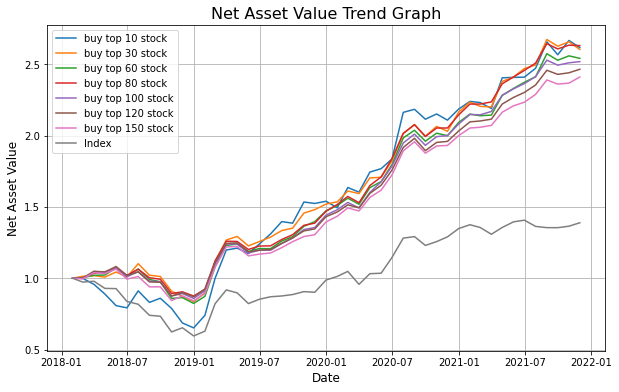

In [125]:
graph(portfolio)

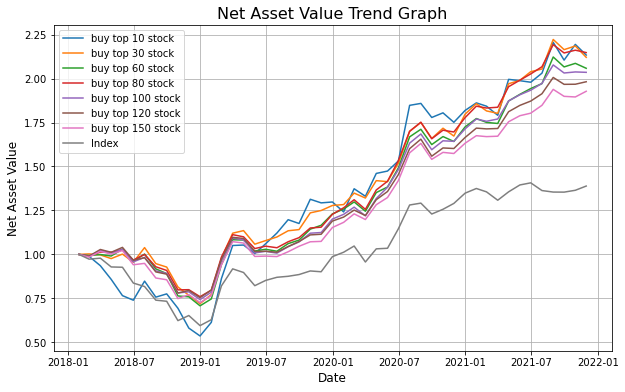

In [126]:
graph(portfolio_cost)

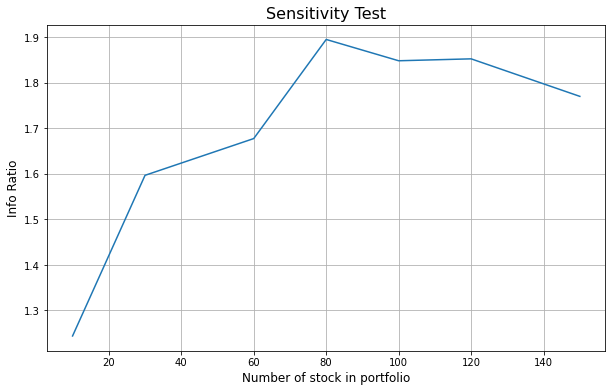

In [62]:
 Sensitivity(evaluation)

In [127]:
print(para.n_stock_buy[3])
trading_book(curr_month,para.n_stock_buy[3])

80


,Bought_on,Code,Close,Monthly_Return,Index_Return,y_score,Signal,Trade Volume,Monthly_Result,Monthly_Profit,Sell_Date
99561,2018-01-31,S.CN.SZSE.000537,17.040001,-0.193236,-0.027003,4.606274,1,74.0,0.0,-24366.234520,2018-02-28
99734,2018-01-31,S.CN.SSE.600507,15.120000,0.271485,-0.027003,2.766975,1,83.0,0.0,34070.240268,2018-02-28
100293,2018-01-31,S.CN.SSE.601003,7.340000,0.063633,-0.027003,2.461343,1,171.0,0.0,7986.843109,2018-02-28
100392,2018-01-31,S.CN.SSE.601155,40.220001,-0.149824,-0.027003,2.349961,1,32.0,0.0,-19282.982359,2018-02-28
99507,2018-01-31,S.CN.SSE.600338,34.150002,0.087682,-0.027003,2.083199,1,37.0,0.0,11079.060710,2018-02-28
...,...,...,...,...,...,...,...,...,...,...,...
153879,2021-11-30,S.CN.SSE.688188,415.640015,-0.068195,0.005192,-0.080947,1,4.0,0.0,-11337.766433,2021-12-31
153170,2021-11-30,S.CN.SZSE.000799,224.580002,-0.049848,0.005192,-0.085527,1,6.0,0.0,-6716.905001,2021-12-31
154026,2021-11-30,S.CN.SZSE.002557,53.580002,0.143861,0.005192,-0.087617,1,24.0,0.0,18499.373800,2021-12-31
153380,2021-11-30,S.CN.SSE.600563,261.200012,-0.109377,0.005192,-0.098657,1,5.0,0.0,-14284.694827,2021-12-31
